# The ML model of CTR prediction

This is the analysis of ads generated through 11 days and known as **Avazu** data. The project follows Data Collection, EDA, Data cleaning, modeling, it's evaluation & deployment.|

In [1]:
# Importing libraries

import numpy as np             # Mathetimatical Operations
import pandas as pd            # Data manipulation
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

# Scipy
import scipy
from scipy import stats
import scipy.stats as ss

# Sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

# XGBoost
import xgboost as xgb

# Tensorflow
import tensorflow as tf

# Other
import itertools
from tqdm import tqdm
from mlxtend.preprocessing import minmax_scaling
from typing import Union
from wordcloud import WordCloud, STOPWORDS
import gzip
import timeit
import warnings
warnings.filterwarnings('ignore')

# Data collection

In [2]:
df = pd.read_csv('data/train.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
# validation_df = pd.read_csv('sampleSubmission.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
# test_df = pd.read_csv('test.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)

# Exploratory Data Analysis

In [3]:
# First look at the data
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


### Respective data fields

* *id*: ad identifier such as 1000009418151094273, 10000169349117863715
* *click*: 0 for non-click, 1 for click
* *hour*: in the format of YYMMDDHH, for example 21090200
* *C1*: anonymized categorical variable, such as 1005, 1002
* *banner_pos*: where a banner is located - 1 and 0
* *site_id*: site_identifier, such as 1fb01fe, fe8cc448, d6137915
* *site_domain*: hashed site category, such as 'bb1ef334', 'f3845767'
* *site_category*: hashed site category, such as 18905ebd, 28905ebd
* *app_id*: mobile app identifier
* app_domain
* app_category
* *device_id*: mobile device identifier
* *device_ip*: IP address
* *device_model*: such as iPhone6, Samsung - hashed
* *device_type*: such as tablet, smartphone - hashed
* *device_conn_type*: Wi-Fi or 3G for example - again hashed
* *C14-C21*: anonymized categorical variables

1. Looking at the data types

In [4]:
df.info()
# df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 7.2+ GB


2. How many oberevations each feature has?

In [5]:
for name in df.columns:
    print("%s: %s" % (name, len(df[name].unique())))

id: 40428967
click: 2
hour: 240
C1: 7
banner_pos: 7
site_id: 4737
site_domain: 7745
site_category: 26
app_id: 8552
app_domain: 559
app_category: 36
device_id: 2686408
device_ip: 6729486
device_model: 8251
device_type: 5
device_conn_type: 4
C14: 2626
C15: 8
C16: 9
C17: 435
C18: 4
C19: 68
C20: 172
C21: 60


3. How many observations and features there are?

In [6]:
print("Observations: " + str(len(df.index)))
print("Features: " + str(len(df.columns)))

# # Alternative way:
# train_df.shape

Observations: 40428967
Features: 24


4. Which of the features are numeric?

In [7]:
cols = df.columns
num_cols = df._get_numeric_data().columns
num_cols

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21'],
      dtype='object')

5. Which features are categorical?

In [8]:
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['device_ip',
 'site_category',
 'device_model',
 'app_domain',
 'device_id',
 'app_category',
 'site_domain',
 'site_id',
 'app_id']

6. Looking at clicks

Number of customers who didnt click on ad: 33563901
Number of customers who clicked: 6865066
Percentage of apply to non apply 4.889086426845714 %


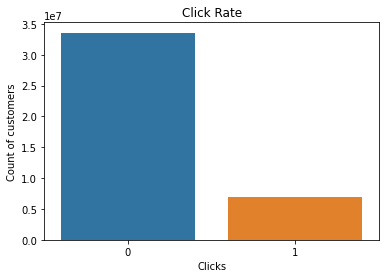

In [9]:
sns.countplot(x='click', data=df);
plt.title('Click Rate')
plt.ylabel('Count of customers')
plt.xlabel('Clicks')

print('Number of customers who didnt click on ad:',df['click'].value_counts()[0])
print('Number of customers who clicked:',df['click'].value_counts()[1])
print('Percentage of apply to non apply',df['click'].value_counts()[0]/df['click'].value_counts()[1],'%')

**Observation**
The data is imbalanced and so we might have to use techniques like resampling (undersampling or oversampling) or use metrics like AUC-ROC curve or AUPRC or SMOTE to handle imbalanced data. Lets explore further which will help us decide what technique should we use. Note: It is already given in the dataset that I have to use AUC as the metric.

7. Checking the correlation between features


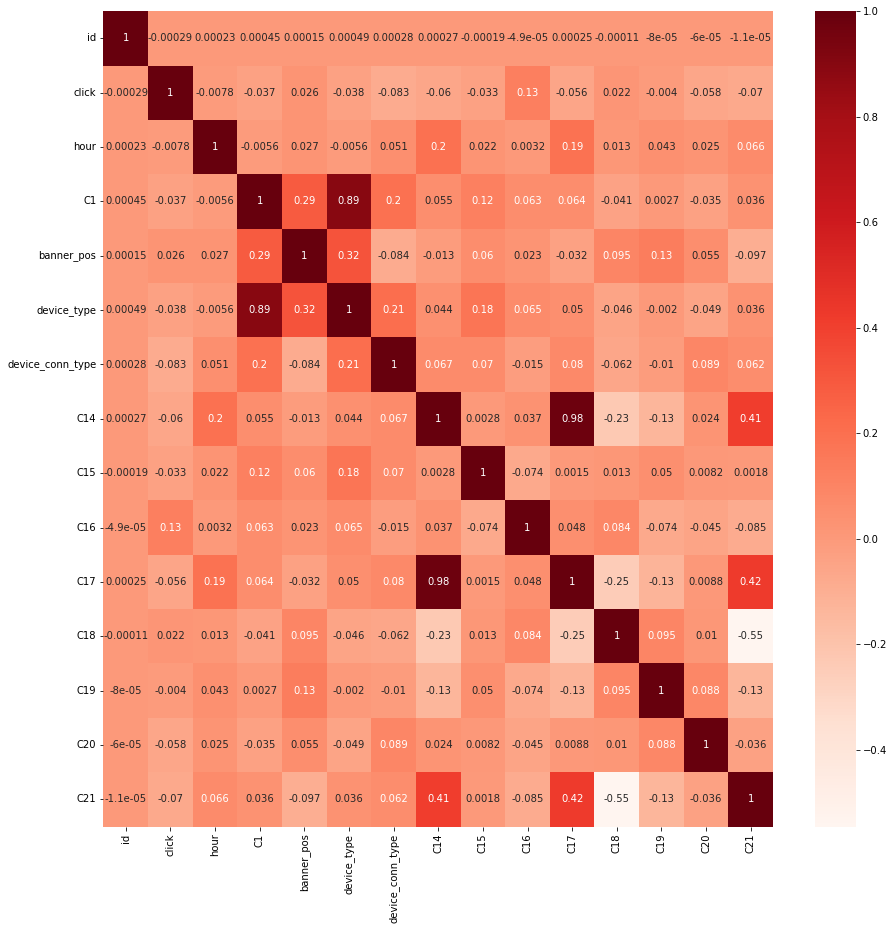

In [10]:
cor = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

**Observation:** 
After correlation and data type inspection it seems safe to drop features of 'id', 'click', 'hour', device_id' & 'device_ip'.

8. Checking outliers

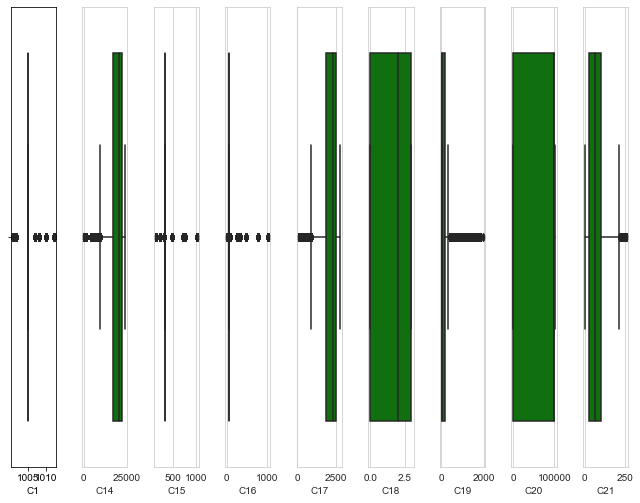

In [11]:
l = ['C1', 'C14',
       'C15', 'C16', 'C17',
       'C18','C19', 'C20', 'C21']
number_of_columns=9
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,7*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='green',orient='v')
    plt.tight_layout()

**Observation:**
As we see there are a lot of outliers in the data

9. Checking the statistics

In [12]:
df.describe(include = 'all')

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,4.042897e+07,4.042897e+07,4.042897e+07,4.042897e+07,4.042897e+07,40428967,40428967,40428967,40428967,40428967,...,4.042897e+07,4.042897e+07,4.042897e+07,4.042897e+07,4.042897e+07,4.042897e+07,4.042897e+07,4.042897e+07,4.042897e+07,4.042897e+07
unique,NaN,NaN,NaN,NaN,NaN,4737,7745,26,8552,559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,85f751fd,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,14596137,15131739,16537234,25832830,27237087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.223017e+18,1.698056e-01,1.410256e+07,1.004968e+03,2.880146e-01,NaN,NaN,NaN,NaN,NaN,...,1.015305e+00,3.313150e-01,1.884181e+04,3.188831e+02,6.010201e+01,2.112601e+03,1.432499e+00,2.271444e+02,5.321685e+04,8.338229e+01
std,5.325443e+18,3.754620e-01,2.966837e+02,1.094586e+00,5.063820e-01,NaN,NaN,NaN,NaN,NaN,...,5.274336e-01,8.547935e-01,4.959457e+03,2.127250e+01,4.729538e+01,6.094124e+02,1.326227e+00,3.510221e+02,4.995682e+04,7.028996e+01
min,5.211594e+11,0.000000e+00,1.410210e+07,1.001000e+03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,3.750000e+02,1.200000e+02,2.000000e+01,1.120000e+02,0.000000e+00,3.300000e+01,-1.000000e+00,1.000000e+00
25%,4.611181e+18,0.000000e+00,1.410230e+07,1.005000e+03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,0.000000e+00,1.692000e+04,3.200000e+02,5.000000e+01,1.863000e+03,0.000000e+00,3.500000e+01,-1.000000e+00,2.300000e+01
50%,9.223224e+18,0.000000e+00,1.410260e+07,1.005000e+03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,0.000000e+00,2.034600e+04,3.200000e+02,5.000000e+01,2.323000e+03,2.000000e+00,3.900000e+01,1.000480e+05,6.100000e+01
75%,1.383561e+19,0.000000e+00,1.410281e+07,1.005000e+03,1.000000e+00,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,0.000000e+00,2.189400e+04,3.200000e+02,5.000000e+01,2.526000e+03,3.000000e+00,1.710000e+02,1.000930e+05,1.010000e+02


10. Checking the distribution
*Positive* refers to the fact that a customer clicked on an ad while *Negative* he/she - didn't

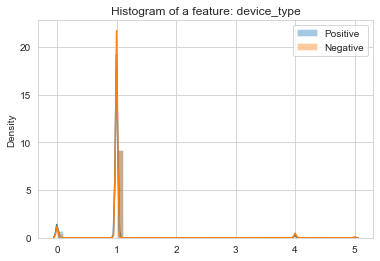

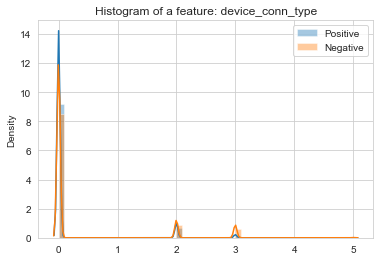

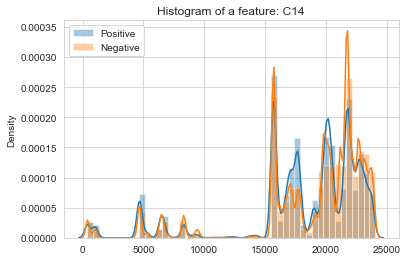

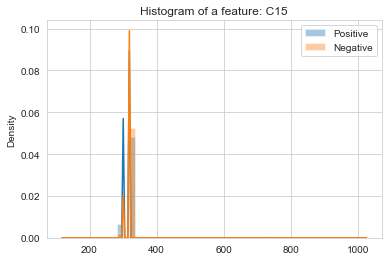

In [13]:
for feature in df.columns[14:18]:
    ax = plt.subplot()
    sns.distplot(df[df['click'] == 1][feature], bins=50, label='Positive')
    sns.distplot(df[df['click'] == 0][feature], bins=50, label='Negative')
    ax.set_xlabel('')
    ax.set_title('Histogram of a feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()

**Observation:**
The linearity of some variables is a good practice to plot distribution graph and look for skewness of features. Kernel density estimate (kde) was a useful tool for plotting the shape of a distribution. From here that there seems to be some symmetry amongst the features we inspected. 


# Data Cleaning

1. Checking if there are any duplicates

In [14]:
df.duplicated(df.columns)
df.duplicated(df.columns).sum()

0

2. Checking if there are null values


In [15]:
df.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

3. Checking value counts for device_type feature

In [16]:
df['device_type'].value_counts().head()

1    37304667
0     2220812
4      774272
5      129185
2          31
Name: device_type, dtype: int64

**Observation:**
Because there aren't null values, so we don't have to consider imputing those features or dealing with null values at all.

**Note: I will not be removing outliers since there is possibility of them carrying important information which can help us detect the apply and non apply cases**

# Modelling

Involves **Feature Engineering** by removing unused features 


In [25]:
n_rows = 300000

X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip'], axis=1).values
# X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip'], axis=1).valuessite_id           object 
Y = df['click'].values

print(X.shape)

n_train = int(n_rows * 0.9)
X_train = X[:n_train]
Y_train = Y[:n_train]
X_test = X[n_train:]
Y_test = Y[n_train:]

enc = OneHotEncoder(handle_unknown='ignore')
X_train_enc = enc.fit_transform(X_train)

X_train_enc[0]
print(X_train_enc[0])

X_test_enc = enc.transform(X_test)

(40428967, 19)
  (0, 2)	1.0
  (0, 6)	1.0
  (0, 188)	1.0
  (0, 2608)	1.0
  (0, 2679)	1.0
  (0, 3771)	1.0
  (0, 3885)	1.0
  (0, 3929)	1.0
  (0, 4879)	1.0
  (0, 7315)	1.0
  (0, 7319)	1.0
  (0, 7475)	1.0
  (0, 7824)	1.0
  (0, 7828)	1.0
  (0, 7869)	1.0
  (0, 7977)	1.0
  (0, 7982)	1.0
  (0, 8021)	1.0
  (0, 8189)	1.0


In [27]:
X = df.drop('click',axis=1)
y = df.click

Assigning numerical and caetgorical variables

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [29]:
num_cols = X.select_dtypes(include = ['int','float']).columns.tolist()
categorical_cols = X.select_dtypes(include = ['object']).columns.tolist()
print(num_cols)
print(categorical_cols)

['id', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


Hashing

In [32]:
for col in categorical_cols:
    X_train[col] = X_train[col].apply(lambda x: hash(x))
    
for col in categorical_cols:
    X_test[col] = X_test[col].apply(lambda x:hash(x))

Scaling the Numerical Values¶

In [33]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train[num_cols] = std.fit_transform(X_train[num_cols])
X_test[num_cols] = std.transform(X_test[num_cols])

In [34]:
X_train['user_info'] = X_train.device_ip + X_train.device_model + X_train.device_id
X_train = X_train.drop(['device_id','device_ip','device_model','id','hour'],axis=1)
    
X_train['device_info'] = X_train.device_type + X_train.banner_pos + X_train.device_conn_type
X_train = X_train.drop(['banner_pos','device_conn_type','device_type'],axis=1)

X_test['user_info'] = X_test.device_ip + X_test.device_model + X_test.device_id
X_test = X_test.drop(['device_id','device_ip','device_model','id','hour'],axis=1)
    
X_test['device_info'] = X_test.device_type + X_test.banner_pos + X_test.device_conn_type
X_test = X_test.drop(['banner_pos','device_conn_type','device_type'],axis=1)

### Decision Tree Classifier (Scipy)

In [35]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 10)
tree.fit(X_train,y_train)
print('Train Score:',tree.score(X_train,y_train))
print('Test Score:',tree.score(X_test,y_test))

Train Score: 0.833970135132251
Test Score: 0.8341246388418998


In [36]:
from sklearn.metrics import roc_curve,confusion_matrix,precision_score,recall_score,roc_auc_score
y_score = tree.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc_score = roc_auc_score(y_test,y_score[:,1])
print(roc_auc_score)

0.709738282178414


In [37]:
y_pred = tree.predict(X_test)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
print("Precision: %s, Recall: %s" %(precision, recall))

Precision: 0.7973043665058606, Recall: 0.8341246388418998


In [38]:
matrix = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = matrix.ravel()
print(matrix)

[[9967928  102602]
 [1909249  148912]]


In [39]:
for max_depth_val in [2, 3, 5, 10, 15, 20]:
    clf = DecisionTreeClassifier(max_depth = max_depth_val)
    print("Evaluating tree with max_depth = %s" %(max_depth_val))
    y_pred = tree.fit(X_train,y_train).predict(X_test) 
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, y_pred))
    prec = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')
    print("Precision: %s, Recall: %s" %(prec, recall))

Evaluating tree with max_depth = 2
Confusion matrix: 
[[9967926  102604]
 [1909247  148914]]
Precision: 0.7973042129208712, Recall: 0.8341246388418998
Evaluating tree with max_depth = 3
Confusion matrix: 
[[9967927  102603]
 [1909244  148917]]
Precision: 0.7973056252915109, Recall: 0.8341249686384128
Evaluating tree with max_depth = 5
Confusion matrix: 
[[9967929  102601]
 [1909247  148914]]
Precision: 0.7973054449990506, Recall: 0.8341248861892846
Evaluating tree with max_depth = 10
Confusion matrix: 
[[9967931  102599]
 [1909247  148914]]
Precision: 0.7973062664003762, Recall: 0.8341250510875411
Evaluating tree with max_depth = 15
Confusion matrix: 
[[9967930  102600]
 [1909245  148916]]
Precision: 0.797306523484709, Recall: 0.8341251335366694
Evaluating tree with max_depth = 20
Confusion matrix: 
[[9967926  102604]
 [1909245  148916]]
Precision: 0.7973048807114375, Recall: 0.8341248037401563


In [40]:
from sklearn.model_selection import KFold,cross_val_score
for max_depth_val in [3, 5, 10]:
    k_fold = KFold(n_splits = 4)
    clf = DecisionTreeClassifier(max_depth = max_depth_val)
    print("Evaluating Decision Tree for max_depth = %s" %(max_depth_val))
    y_pred = tree.fit(X_train, y_train).predict(X_test) 
  
    cv_precision = cross_val_score(clf, X_train, y_train, cv = k_fold, scoring = 'recall_weighted')
    precision = recall_score(y_test, y_pred, average = 'weighted')
    print("Cross validation Recall: %s" %(cv_precision.mean()))
    print("Test Recall: %s" %(precision.mean()))

Evaluating Decision Tree for max_depth = 3
Cross validation Recall: 0.8301463561698126
Test Recall: 0.8341252159857977
Evaluating Decision Tree for max_depth = 5
Cross validation Recall: 0.8316839383474565
Test Recall: 0.8341248037401563
Evaluating Decision Tree for max_depth = 10
Cross validation Recall: 0.8339429975877267
Test Recall: 0.8341251335366694


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [10], 
    'n_estimators':[2,5,10,20,50],
    'min_samples_split': [2, 3, 4],
    'max_features' : ['log2']
}

rf = RandomForestClassifier(random_state=42)

rf_search = RandomizedSearchCV(estimator = rf, param_distributions=param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, n_iter = 10)

model = rf_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_split=3, n_estimators=2; total time=13.7min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_split=4, n_estimators=10; total time=40.4min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_split=3, n_estimators=10; total time=44.6min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_split=4, n_estimators=10; total time=38.9min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_split=2, n_estimators=10; total time=37.6min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_split=3, n_estimators=20; total time=81.0min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_split=4, n_estimators=2; total time=10.4min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_split=2, n_estimators=10; total time=40.1min
[CV] END bootstrap=Tr

In [42]:
rf_search.best_params_

{'n_estimators': 20,
 'min_samples_split': 3,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

### Random Forest Classifier (Scipy)

In [43]:
clf_rf = RandomForestClassifier(n_estimators= 20,
 min_samples_split= 2,
 max_features= 'log2',
 max_depth= 10,
 bootstrap= True,
 random_state=42)
clf_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=20,
                       random_state=42)

In [44]:
rf_prob = clf_rf.predict_proba(X_test)
rf_fpr,rf_tpr,_ = roc_curve(y_test,rf_prob[:,1])

### XGB Classifier

In [52]:
import xgboost as xgb
from sklearn.metrics import roc_curve,auc,confusion_matrix,precision_score,recall_score,roc_auc_score
params = {
    "objective": "binary:logistic",
    "booster" : "gbtree",
    "eval_metric": "logloss",
    "eta":0.1,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "verbosity": 0,
}
xgclf=xgb.XGBClassifier(**params)
xgclf.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='logloss',
        verbose=False)
xgpred=xgclf.predict_proba(X_test)

In [53]:
from sklearn import metrics 
#y_score = xgclf.predict_proba(x_test)
#fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc_score = metrics.roc_auc_score(y_test,xgpred[:,1])
print(roc_auc_score)
print(xgclf.score(X_test,y_test))
xgb_fpr,xgb_tpr,_ = roc_curve(y_test,xgpred[:,1])

0.7378860752085188
0.8344185699841805


In [54]:
from sklearn.model_selection import KFold,cross_val_score
# Set up k-fold
k_fold = KFold(n_splits = 5)

# Evaluate precision and recall for each fold
precision = cross_val_score(
  xgclf, X_train, y_train, cv = k_fold, scoring = 'precision_weighted')
recall = cross_val_score(
  xgclf, X_train, y_train, cv = k_fold, scoring = 'recall_weighted')
print("Precision scores: %s" %(precision.mean())) 
print("Recall scores: %s" %(recall.mean()))
print(k_fold)

Precision scores: 0.798844500651994
Recall scores: 0.8342281891524573
KFold(n_splits=5, random_state=None, shuffle=False)


In [55]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

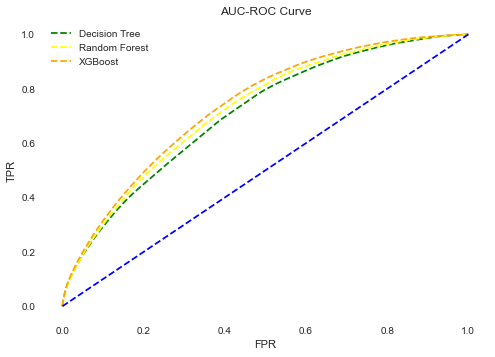

In [60]:
plt.rcParams['axes.facecolor'] = 'white'
# plt.style.use('seaborn')
plt.plot(fpr,tpr,linestyle = '--',color = 'green',label='Decision Tree')
plt.plot(rf_fpr,rf_tpr,linestyle = '--',color = 'yellow',label='Random Forest')
plt.plot(xgb_fpr,xgb_tpr,linestyle = '--',color = 'orange',label='XGBoost')
plt.plot(p_fpr,p_tpr,linestyle='--',color = 'blue')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC-ROC Curve');

In [2]:
# Solution for importing if the path is different:
# import sys  
# !{sys.executable} -m pip install --user wordcloud

# Conclusion

Technique that showed best performance on the data was that of XGBoost classifier followed by Random Forest and Decision Tree clasifiers.